In [225]:
%%bash
# These files appear to be from the original competition (that is unmodified)
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.db
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.sql

In [226]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import numpy as np

from patsy import dmatrices

from contextlib import closing

from pandas.api.types import CategoricalDtype
from pandas_ml import ConfusionMatrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [227]:
seed = 13431
np.random.seed(seed)

with closing(sqlite3.connect('file:compData.db?mode=ro', uri=True)) as conn:    
    patientTranscripts = pd.read_sql_query("""
    SELECT PatientGuid,
        dmIndicator,
        Gender,
        YearOfBirth,
        VisitYear,
        CASE WHEN BMI = 0 THEN NULL ELSE BMI END AS BMI,
        CASE WHEN SystolicBP = 'NULL' THEN NULL ELSE SystolicBP END AS SystolicBP,
        CASE WHEN DiastolicBP = 'NULL' THEN NULL ELSE DiastolicBP END AS DiastolicBP
    FROM training_patientTranscript
""", conn)
  
    patientIcd9Codes = pd.read_sql_query("""
SELECT PatientGuid, ICD9Code
FROM training_diagnosis 
""", conn)
    
    # Note: Need to use training_patientSmokingStatus directly rather than patient_smoking
    # as the NIST codes used translate to multiple statuses
    patientSmokingStatus = pd.read_sql_query("""
SELECT PatientGuid, 
    EffectiveYear,
    SmokingStatusGuid
FROM training_patientSmokingStatus
""", conn)
    
    preDbMatch = pd.read_sql_query("""
SELECT DISTINCT PatientGuid
FROM training_diagnosis 
WHERE ICD9Code IN ('790.29','648.83')
""", conn)

In [1]:
# https://www.cdc.gov/healthyweight/assessing/index.html
def translateBMI(bmi):
    if bmi <  18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return  'Normal'
    elif 25 <= bmi <= 29.9:
        return 'Overweight'
    else:
        return 'Obese'
        
# https://www.heart.org/HEARTORG/Conditions/HighBloodPressure/KnowYourNumbers/Understanding-Blood-Pressure-Readings_UCM_301764_Article.jsp
def translateBP(systolicBP, diastolicBP):
    if systolicBP < 120 and diastolicBP < 80:
        return 'Normal'
    elif systolicBP <= 129 and diastolicBP < 80:
        return 'Elevated'
    elif systolicBP <= 139 or 80 <= diastolicBP <= 89:
        return 'HTN_S1'
    elif 140 <= systolicBP or 90 <= diastolicBP:
        return 'HTN_S2'
    else:
        return 'Hypertensive_Crisis'

def calcAge(yearOfBirth):
    return 2012 - yearOfBirth

def isPreDB(patientGuid):
    return patientGuid in preDbMatch.PatientGuid.values

def isSmoker(ps, patientGuid):
    return patientGuid in ps.index and ps.loc[patientGuid, 'SmokingStatusGuid'] in ('FA2B7AE4-4D14-4768-A8C7-55B5F0CDF4AF', 
                                                                                    '02116D5A-F26C-4A48-9A11-75AC21BC4FD3', \
                                                                                    'DD01E545-D7AF-4F00-B248-9FD40010D81D', \
                                                                                    'FCD437AA-0451-4D8A-9396-B6F19D8B25E8', \
                                                                                    '2548BD83-03AE-4287-A578-FA170F39E32F')

def processPatientTranscripts(pt):
    pt = pt.sort_values(['VisitYear'],  ascending=False)
    pt = pt.groupby('PatientGuid', as_index=False).agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])

    pt['dmIndicator'] = pt['dmIndicator'].astype('bool')
    pt['Gender'] = pt['Gender'].astype('category')
    pt['Age'] = pt.apply(lambda row: calcAge(row.YearOfBirth), axis=1)
    pt['PreDB'] = pt.apply(lambda row: isPreDB(row.PatientGuid), axis=1)
    
    pt.drop(['VisitYear', 'YearOfBirth'], axis=1, inplace=True)
    pt.dropna(how='any', inplace=True)
    
    bmi_type = CategoricalDtype(categories=['Underweight', 'Normal', 'Overweight', 'Obese'], ordered=True)
    pt['BMICategory'] = pt.apply(lambda row: translateBMI(row.BMI), axis=1).astype(bmi_type)
    bp_type = CategoricalDtype(categories=['Normal', 'Elevated', 'HTN_S1', 'HTN_S2'], ordered=True)
    pt['BPCategory'] = pt.apply(lambda row: translateBP(row.SystolicBP, row.DiastolicBP), axis=1).astype(bp_type)
    
    pt['SystolicBP'] = pt['SystolicBP'].astype('int')
    pt['DiastolicBP'] = pt['DiastolicBP'].astype('int')
    
    return pt

def processPatientSmoking(ps):
    ps = ps.sort_values(['EffectiveYear'], ascending=False)
    ps = ps.groupby('PatientGuid').agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])
    
    ps['Smoker'] = ps.apply(lambda row: isSmoker(ps, row.name), axis=1)
    
    ps.drop(['EffectiveYear', 'SmokingStatusGuid'], axis=1, inplace=True)
    ps.dropna(how='any', inplace=True)
    ps.reset_index(level=0, inplace=True)

    return ps


In [229]:
transcripts = processPatientTranscripts(patientTranscripts)
transcripts.head()

,PatientGuid,dmIndicator,Gender,BMI,SystolicBP,DiastolicBP,Age,PreDB,BMICategory,BPCategory
0,00023761-9D8D-445B-874C-2424CC7CF620,False,M,27.670,122,76,56,False,Overweight,Elevated
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,False,F,22.463,128,82,60,False,Normal,HTN_S1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,False,F,16.654,80,60,87,False,Underweight,Normal
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,False,M,28.190,125,75,42,False,Overweight,Elevated
4,002667F4-B9A3-4DE2-875F-8034DD637865,False,F,19.388,112,80,84,False,Normal,HTN_S1


In [230]:
smokingStatus = processPatientSmoking(patientSmokingStatus)
smokingStatus.head()

,PatientGuid,Smoker
0,000B4862-7CE7-4EC5-8043-A97FCD74BD78,False
1,0029BBC8-7C22-4444-9F44-87BEF05FE033,False
2,003CEE1F-5BF5-4171-9284-F5464EC12D41,False
3,005F61C9-E537-4AD2-B39C-37F25891F33A,False
4,0063B34F-C2C4-423A-A144-E51F7149253A,False


In [231]:
patients = pd.merge(transcripts, smokingStatus, on='PatientGuid', how='left')
patients['Smoker'] = patients['Smoker'].fillna(False)
patients.drop(['PatientGuid'], axis=1, inplace=True)
patients.head()

,dmIndicator,Gender,BMI,SystolicBP,DiastolicBP,Age,PreDB,BMICategory,BPCategory,Smoker
0,False,M,27.670,122,76,56,False,Overweight,Elevated,False
1,False,F,22.463,128,82,60,False,Normal,HTN_S1,False
2,False,F,16.654,80,60,87,False,Underweight,Normal,False
3,False,M,28.190,125,75,42,False,Overweight,Elevated,False
4,False,F,19.388,112,80,84,False,Normal,HTN_S1,False


In [232]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('dmIndicator ~ C(Gender) + C(BMICategory) + C(BPCategory) + Age + PreDB + Smoker',
                  patients, return_type='dataframe')
print(X.columns)

Index(['Intercept', 'C(Gender)[T.M]', 'C(BMICategory)[T.Normal]',
       'C(BMICategory)[T.Overweight]', 'C(BMICategory)[T.Obese]',
       'C(BPCategory)[T.Elevated]', 'C(BPCategory)[T.HTN_S1]',
       'C(BPCategory)[T.HTN_S2]', 'PreDB[T.True]', 'Smoker[T.True]', 'Age'],
      dtype='object')


In [233]:
y = y.iloc[:, 1].astype('bool')

In [234]:
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.80737910927917966

In [235]:
y.mean()

0.19141449683321604

Only 19% of the patients had type 2 diabetes, which means that we could obtain 81% accuracy by always predicting `False`. So we're actually doing *worse* than the null error rate.

In [236]:
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-2.66570922605]
1,C(Gender)[T.M],[0.31659752709]
2,C(BMICategory)[T.Normal],[0.136629603535]
3,C(BMICategory)[T.Overweight],[0.750695164526]
4,C(BMICategory)[T.Obese],[1.39338729504]
5,C(BPCategory)[T.Elevated],[0.0220422353029]
6,C(BPCategory)[T.HTN_S1],[0.118738912773]
7,C(BPCategory)[T.HTN_S2],[0.282356019704]
8,PreDB[T.True],[0.541596444638]
9,Smoker[T.True],[-0.0324645815771]


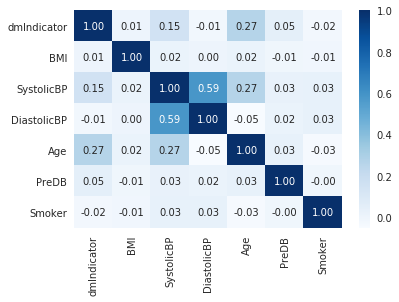

In [303]:
sns.heatmap(patients.corr(), annot=True, fmt='.2f', cmap='Blues');

In [237]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=seed)

In [238]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

print("Accuracy = {:.2f}".format(lr.score(test_X, test_y)))

Accuracy = 0.81


In [295]:
# predict class labels for the test set
predicted = model.predict(test_X)
# generate class probabilities
probs = model.predict_proba(test_X)

print(metrics.accuracy_score(test_y, predicted))
print(metrics.roc_auc_score(test_y, probs[:, 1]))

0.809045226131
0.749246859358


In [294]:
print(metrics.classification_report(test_y, predicted))

             precision    recall  f1-score   support

      False       0.82      0.98      0.89      1617
       True       0.43      0.06      0.10       373

avg / total       0.75      0.81      0.74      1990



In [300]:
binary_confusion_matrix = ConfusionMatrix(test_y, predicted)
print("Binary confusion matrix:\n%s" % binary_confusion_matrix)

Binary confusion matrix:
Predicted  False  True  __all__
Actual                         
False        300     8      308
True          85     2       87
__all__      385    10      395


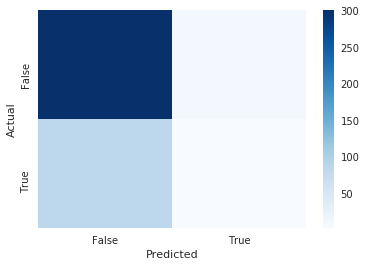

In [304]:
binary_confusion_matrix.plot(backend='seaborn', cmap='Blues');

In [299]:
binary_confusion_matrix.print_stats()

population: 395
P: 87
N: 308
PositiveTest: 10
NegativeTest: 385
TP: 2
TN: 300
FP: 8
FN: 85
TPR: 0.0229885057471
TNR: 0.974025974026
PPV: 0.2
NPV: 0.779220779221
FPR: 0.025974025974
FDR: 0.8
FNR: 0.977011494253
ACC: 0.764556962025
F1_score: 0.0412371134021
MCC: -0.00787634330991
informedness: -0.0029855202269
markedness: -0.0207792207792
prevalence: 0.220253164557
LRP: 0.885057471264
LRN: 1.0030651341
DOR: 0.882352941176
FOR: 0.220779220779


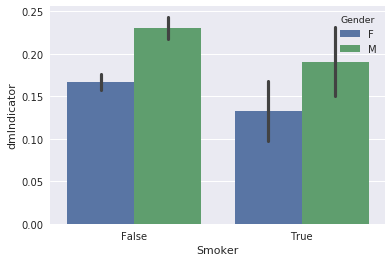

In [242]:
sns.barplot(x="Smoker", y="dmIndicator", hue="Gender", data=patients);

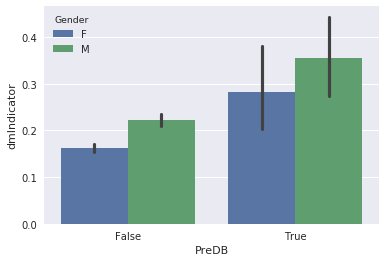

In [243]:
sns.barplot(x="PreDB", y="dmIndicator", hue="Gender", data=patients);

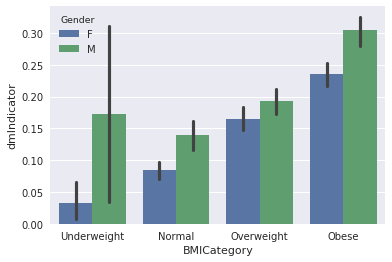

In [244]:
sns.barplot(x="BMICategory", y="dmIndicator", hue="Gender", data=patients);

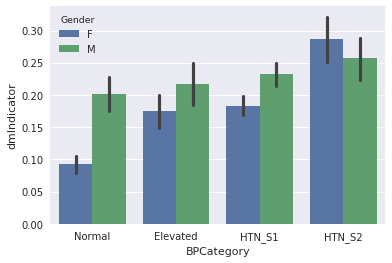

In [245]:
#patients.BPCategory.cat.remove_unused_categories()
sns.barplot(x="BPCategory", y="dmIndicator", hue="Gender", data=patients);

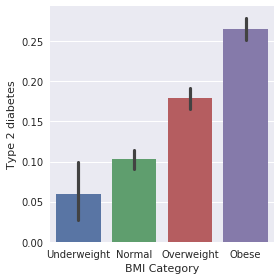

In [251]:
sns.factorplot(x="BMICategory", y="dmIndicator", data=patients, kind="bar")#, ci=None);
plt.xlabel('BMI Category')
plt.ylabel('Type 2 diabetes');


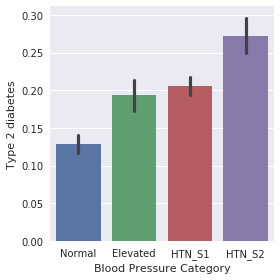

In [252]:
#patients['BPCategory'] = pd.to_numeric(patients['BPCategory'])
sns.factorplot(x="BPCategory", y="dmIndicator", data=patients, kind="bar")#, ci=None)
plt.xlabel('Blood Pressure Category')
plt.ylabel('Type 2 diabetes');